# part0: imports

In [1]:
%matplotlib inline

from tqdm import tqdm
import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")
from IPython.display import clear_output

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection
from matplotlib.backends.backend_pdf import PdfPages


import torch

import pyaldata as pyal

try:
    nbPath = pathlib.Path.cwd()
    RepoPath = nbPath.parent
    os.chdir(RepoPath)

    from tools import utilityTools as utility
    from tools import dataTools as dt
    import params
    defs = params.mouse_defs
    
    set_rc =  params.set_rc_params
    set_rc()
    root = params.root
    reload(dt)
    reload(params)
    reload (defs)
finally:
    os.chdir(nbPath)

print('Done')

Done


---

#### Load the lower bound values for the canonical correlations

takes a couple of minutes to execute.

In [ ]:
%run "_mouse-lower-bound.ipynb"

---

#### Load the upper bound values for the canonical correlations

takes a couple of minutes to execute.

In [ ]:
%run "_mouse-upper-bound.ipynb"

# reading data

In [2]:
animalList = ['mouse-data']

animalFiles = []
for animal in animalList:
    animalFiles.extend(utility.find_file(root / animal, 'mat'))


AllDFs=[]
for fname in animalFiles:
    print(fname)
    df = dt.load_pyal_data(fname)
    df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
    df['file'] = fname.split(os.sep)[-1]
    df = defs.prep_general_mouse(df)
    AllDFs.append(df)

clear_output()

---

# CCA comparison

## 2 mice, same epoch

load the data

In [3]:
# load the DFs
warnings.filterwarnings("ignore")
allDFs_M1 = []
for df in AllDFs:
    if 'M1_rates' in df.columns:
        allDFs_M1.append(df)


allDFs_Str = []
for df in AllDFs:
    if 'Str_rates' in df.columns:
        allDFs_Str.append(df)
warnings.filterwarnings("default")


pairFileList1 = []
for I, df1 in enumerate(allDFs_M1):
    for J, (df2) in enumerate(allDFs_M1):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList1.append((I,J))

print(f'{len(pairFileList1)=}')


pairFileList2 = []
for I, df1 in enumerate(allDFs_Str):
    for J, df2 in enumerate(allDFs_Str):
        if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
        pairFileList2.append((I,J))

print(f'{len(pairFileList2)=}')


len(pairFileList1)=13
len(pairFileList2)=13


collecting all the data in a matrix, `AllData`: $sessions \times targets \times  trials \times time \times PCs$

min_trials=22
min_time=15
min_trials_=22
min_time_=15


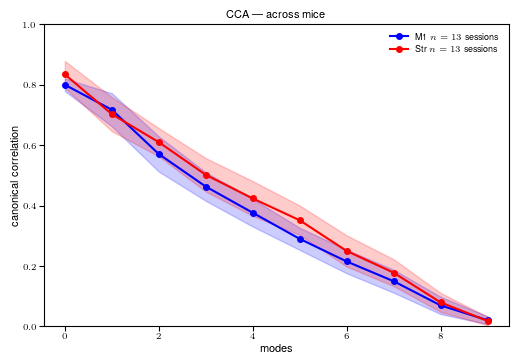

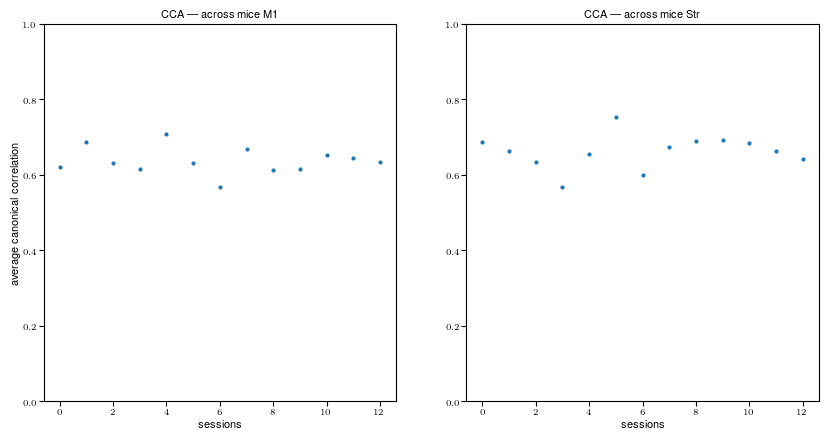

In [4]:
side1df = [allDFs_M1[i] for i,_ in pairFileList1]
side2df = [allDFs_M1[j] for _,j in pairFileList1]
warnings.filterwarnings("ignore")
AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
AllData2 = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')

side1df = [allDFs_Str[i] for i,_ in pairFileList2]
side2df = [allDFs_Str[j] for _,j in pairFileList2]
AllData1_ = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[1], model=defs.n_components)
AllData2_ = dt.get_data_array(side2df, defs.exec_epoch, area=defs.areas[1], model=defs.n_components)
_,_, min_trials_, min_time_,_ = np.min((AllData1_.shape,AllData2_.shape),axis=0)
print(f'{min_trials_=}\n{min_time_=}')
warnings.filterwarnings("default")

allCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
    allCCs0.append(dt.canoncorr(data1, data2))
allCCs0 = np.array(allCCs0).T

allCCs1=[]
for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
    data1 = np.reshape(sessionData1[:,:min_trials_,:min_time_,:], (-1,defs.n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_,:min_time_,:], (-1,defs.n_components))
    allCCs1.append(dt.canoncorr(data1, data2))
allCCs1 = np.array(allCCs1).T

# plot
_,ax = plt.subplots(dpi=100)
utility.shaded_errorbar(ax, allCCs0, color='b', marker = 'o', label=f'{defs.areas[0]} $n={allCCs0.shape[1]}$ sessions')
utility.shaded_errorbar(ax, allCCs1, color='r', marker = 'o', label=f'{defs.areas[1]} $n={allCCs1.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('modes')
ax.legend()
ax.set_ylabel('canonical correlation')
ax.set_title('CCA --- across mice', usetex=True);

_,axes = plt.subplots(ncols=2, figsize=(10,5), dpi=100)
axes[0].plot(allCCs0[:4,:].mean(axis=0),'.')
axes[1].plot(allCCs1[:4,:].mean(axis=0),'.')
axes[0].set_ylabel('average canonical correlation')
for i, ax in enumerate(axes):
    ax.set_title(f'CCA --- across mice {defs.areas[i]} ', usetex=True);
    ax.set_ylim([0,1])
    ax.set_xlabel('sessions')


### Overall Figures

across monkey and within monkey together

In [ ]:
# plot
fig,ax = plt.subplots(ncols=1, figsize=(3,3))

utility.shaded_errorbar(ax, np.arange(1,defs.n_components+1), allCCs0, color='b', marker = 'o', label=f'Across, $n={allCCs0.shape[1]}$')

utility.shaded_errorbar(ax, np.arange(1,defs.n_components+1), CC_upper_bound_M1, color='cornflowerblue', marker = '<', ls='--', label=f'Within, $n={CC_upper_bound_M1.shape[1]}$')

utility.shaded_errorbar(ax, np.arange(1,defs.n_components+1), CC_lower_bound_M1, color='gray', marker = '>', ls=':', label=f'Control, $n={CC_lower_bound_M1.shape[1]}$')


ax.set_ylim([0,1])
ax.set_xlim([.5,defs.n_components+.5])
ax.set_xlabel('Neural mode')
ax.set_title(f'{defs.areas[0]} Alignment')
ax.legend(loc=(.37,.7))
ax.set_ylabel('Canonical correlation')
fig.tight_layout()

fig.savefig(params.figPath / 'mouse-M1-cca-modes.pdf', format='pdf', bbox_inches='tight')

In [ ]:
# plot
fig,ax = plt.subplots(ncols=1, figsize=(3,3))

utility.shaded_errorbar(ax, np.arange(1,defs.n_components+1), allCCs1, color='r', marker = 'o', label=f'Across, $n={allCCs1.shape[1]}$')

utility.shaded_errorbar(ax, np.arange(1,defs.n_components+1), CC_upper_bound_Str, color='lightcoral', marker = '<', ls='--', label=f'Within, $n={CC_upper_bound_Str.shape[1]}$')

utility.shaded_errorbar(ax, np.arange(1,defs.n_components+1), CC_lower_bound_Str, color='gray', marker = '>', ls=':', label=f'Control, $n={CC_lower_bound_Str.shape[1]}$')


ax.set_ylim([0,1])
ax.set_xlim([.5,defs.n_components+.5])
ax.set_xlabel('Neural mode')
ax.set_title(f'{defs.areas[1]} Alignment')
ax.legend(loc=(.37,.7))
ax.set_ylabel('Canonical correlation')
fig.tight_layout()

fig.savefig(params.figPath / 'mouse-Str-cca-modes.pdf', format='pdf', bbox_inches='tight')

comapring group correlations
>Like the NN paper, _Fig. 4e_.

In [ ]:
fig,ax = plt.subplots(ncols=1, figsize=(3,3))
bins = np.arange(0,1,0.05)

ax.hist(allCCs0[:4,:].mean(axis=0), bins=bins, density=True,
        color='b', alpha=.8, label=f'across, $n={allCCs0[:4,:].mean(axis=0).shape[0]}$')
ax.hist(CC_upper_bound_M1[:4,:].mean(axis=0), bins=bins, density=True,
        color='cornflowerblue', alpha=.8, label=f'within, $n={CC_upper_bound_M1[:4,:].mean(axis=0).shape[0]}$')
ax.hist(CC_lower_bound_M1[:4,:].mean(axis=0), bins=bins, density=True,
        color='gray', alpha=.8, label=f'control, $n={CC_lower_bound_M1[:4,:].mean(axis=0).shape[0]}$')

ax.set_title(f'Average of top 4 CCs in {defs.areas[0]}')
ax.set_xlim([0,1])
ax.set_xlabel('Canonical correlation')
ax.set_ylabel('Probability density')
# ax.set_yticks([])
ax.legend(loc=2)

fig.savefig(params.figPath / 'mouse-M1-cca-dist.pdf', format='pdf', bbox_inches='tight')

In [ ]:
fig,ax = plt.subplots(ncols=1, figsize=(3,3))
bins = np.arange(0,1,0.05)

ax.hist(allCCs1[:4,:].mean(axis=0), bins=bins, density=True,
        color='r', alpha=.8, label=f'across, $n={allCCs1[:4,:].mean(axis=0).shape[0]}$')
ax.hist(CC_upper_bound_Str[:4,:].mean(axis=0), bins=bins, density=True,
        color='lightcoral', alpha=.8, label=f'within, $n={CC_upper_bound_Str[:4,:].mean(axis=0).shape[0]}$')
ax.hist(CC_lower_bound_Str[:4,:].mean(axis=0), bins=bins, density=True,
        color='gray', alpha=.8, label=f'control, $n={CC_lower_bound_Str[:4,:].mean(axis=0).shape[0]}$')

ax.set_title(f'Average of top 4 CCs in {defs.areas[1]}')
ax.set_xlim([0,1])
ax.set_xlabel('Canonical correlation')
ax.set_ylabel('Probability density')
# ax.set_yticks([])
ax.legend(loc=2)

fig.savefig(params.figPath / 'mouse-Str-cca-dist.pdf', format='pdf', bbox_inches='tight')

---

## one mouse, 2 epochs

as an extra control

In [ ]:
warnings.filterwarnings("ignore")
side1df = allDFs_M1
AllData1 = dt.get_data_array(side1df, fixation_epoch, area=areas[0], model=n_components)
AllData2 = dt.get_data_array(side1df, exec_epoch, area=areas[0], model=n_components)
_,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
print(f'{min_trials=}\n{min_time=}')

# PMd
side2df = allDFs_Str
AllData1_ = dt.get_data_array(side2df, fixation_epoch, area=areas[1], model=n_components)
AllData2_ = dt.get_data_array(side2df, exec_epoch, area=areas[1], model=n_components)
_,_, min_trials_, min_time_,_ = np.min((AllData1_.shape,AllData2_.shape),axis=0)
print(f'{min_trials_=}\n{min_time_=}')

inCCs0=[]
for sessionData1,sessionData2 in zip(AllData1,AllData2):
    data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,n_components))
    data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,n_components))
    inCCs0.append(dt.canoncorr(data1, data2))
inCCs0 = np.array(inCCs0).T

inCCs1=[]
for sessionData1,sessionData2 in zip(AllData1_,AllData2_):
    data1 = np.reshape(sessionData1[:,:min_trials_,:min_time_,:], (-1,n_components))
    data2 = np.reshape(sessionData2[:,:min_trials_,:min_time_,:], (-1,n_components))
    inCCs1.append(dt.canoncorr(data1, data2))
inCCs1 = np.array(inCCs1).T
warnings.filterwarnings("default")

# plotting
_,ax = plt.subplots()

utility.shaded_errorbar(ax, inCCs0, color='b', marker = 'o', label=f'{areas[0]} $n={inCCs0.shape[1]}$ sessions')
utility.shaded_errorbar(ax, inCCs1, color='r', marker = 'o', label=f'{areas[1]} $n={inCCs1.shape[1]}$ sessions')
ax.set_ylim([0,1])
ax.set_xlabel('components')
ax.legend()
ax.set_ylabel('canonical correlation')
ax.set_title('CCA --- within mouse', usetex=True);

fig,axes = plt.subplots(ncols=2, figsize=(10,5))
axes[0].plot(inCCs0[:4,:].mean(axis=0),'.')
axes[1].plot(inCCs1[:4,:].mean(axis=0),'.')
axes[0].set_ylabel('average canonical correlation')
for i, ax in enumerate(axes):
    ax.set_title(f'CCA --- within mouse {areas[i]} ', usetex=True);
    ax.set_ylim([0,1])
    ax.set_xlabel('sessions')

# Check time gap effect on CCs

In [ ]:
def get_full_mouse_data():  
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

In [ ]:
Range = np.arange(-10,10)  # range of time lags to include

def plot_mouse_cca(allDFs_M1, epoch):   
    pairFileList1 = []
    for I, df1 in enumerate(allDFs_M1):
        for J, (df2) in enumerate(allDFs_M1):
            if J<=I or df1.mouse[0] == df2.mouse[0]: continue  # repetitions
            pairFileList1.append((I,J))
    side1df = [allDFs_M1[i] for i,_ in pairFileList1]
    side2df = [allDFs_M1[j] for _,j in pairFileList1]
    AllData1 = dt.get_data_array(side1df, defs.exec_epoch, area=defs.areas[0], model=defs.n_components)
    AllData2 = dt.get_data_array(side2df, epoch,           area=defs.areas[0], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T
    return allCCs, pairFileList1

def calc_time_lag(allDFs):
    allCCs = []
    for i in Range:
        exec_epoch = pyal.generate_epoch_fun(start_point_name='idx_movement_on',
                                        rel_start=int(defs.WINDOW_exec[0]/defs.BIN_SIZE)+i,
                                        rel_end=int(defs.WINDOW_exec[1]/defs.BIN_SIZE)+i
                                        )
        CCs, pairFileList = plot_mouse_cca(allDFs, exec_epoch)
        allCCs.append(CCs)
    allCCs = np.transpose(np.array(allCCs), (2,1,0))
    sum_CC =  np.sum(allCCs[:,:4,:], axis=1)
    return sum_CC, pairFileList

In [ ]:
if "__file__" not in dir():

    allDFs_M1, allDFs_Str = get_full_mouse_data(); clear_output()

    M1_CC, pairFileList = calc_time_lag(allDFs_M1)
    Str_CC, _ = calc_time_lag(allDFs_Str)

In [ ]:
print(f'{M1_CC.shape=}')
print(f'\nNumber of lags to maximise the sum of the top-4 CCs for each pair of sessions:\n{Range[np.argmax(M1_CC, axis=1)]}')
print(f'\nThe sum of top-4 CCs increases by:\n{M1_CC[range(M1_CC.shape[0]),np.argmax(M1_CC, axis=1)] - M1_CC[range(M1_CC.shape[0]), np.nonzero(Range==0)[0][0]]}')

In [ ]:
bin_30ms = [0.00909705, 0,0.02481727, 0.01705521, 0.01653742, 0.03558858, 0.06250862, 0.03266727, 0.06023451, 0.11097732, 0.00053827, 0.01084072, 0.06272512]
bin_10_ms = [0.00537624, 0.0043734,  0.00534582, 0.04118834, 0.00638328, 0.00225867, 0.03570158, 0, 0.03576609, 0.05293803, 0.00430918, 0.05681727, 0.05909097]
bin_50_ms = [0, 0.01073184, 0.03604887, 0.03170565, 0.02391444, 0.03393483, 0.02231379, 0.01526712, 0.03660592, 0.07538286, 0.00877729, 0, 0.0305291]

In [ ]:
plt.figure(dpi=100)
plt.plot(bin_10_ms,'r', label='bin=10ms')
plt.plot(bin_30ms,'k',label='bin=30ms')
plt.plot(bin_50_ms,'b',label='bin=50ms')
plt.xlabel('pairs of sessions from different animals')
plt.legend()
plt.title('amount of increase in the sum of the top 4 CCs\nby choosing the "best" time lag')

### Saving pickles indicating the optimal time lag value for each pair of sessions

In [ ]:
def save_mouse_lag_pickles(allDFs):
    all_CC, pairFileList = calc_time_lag(allDFs)

    pathPickle = root / 'mouse-data'
    for ind, (i,j) in enumerate(pairFileList):
        bin_shift = Range[np.argmax(all_CC, axis=1)][ind]

        df1 = allDFs[i]
        df2 = allDFs[j]
        pickleFile1 = pathPickle / f'lag-{df1.file[0]}-{df2.file[0]}.p'
        pickleFile2 = pathPickle / f'lag-{df2.file[0]}-{df1.file[0]}.p'
        
        print(f'{pickleFile1}: {bin_shift}')

        with open(pickleFile1, 'wb') as f:
            pickle.dump(bin_shift, f)
            f.close()
        with open(pickleFile2, 'wb') as f:
                pickle.dump(bin_shift, f)
                f.close()



In [ ]:
save_mouse_lag_pickles(allDFs_M1)

In [ ]:
with open("/home/jcc319/multi_animal_alignment/data/mouse-data/lag-js2p0_tbytSpkHandJsTrj10msBin_WR40_082019_ss.mat-js2p0_tbytSpkHandJsTrj10msBin_WR38_052219_ss.mat.p",'rb') as f:
    r = pickle.load(f)
r